# Probability Fundamentals for Language Models

By Graham Neubig for [11-664/763 Inference Algorithms for Language Modeling](https://phontron.com/class/lminference-fall2025/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neubig/lminference-fall2025-code/blob/main/02-generation-basics/probability.ipynb)

This notebook explores the fundamental probability concepts that underlie language models and text generation. We'll cover key mathematical concepts and their PyTorch implementations, building intuition for how sampling strategies work in practice.

## Learning Objectives
- Understand joint and conditional probabilities and their role in language modeling
- Work with latent variables and marginalization
- Implement sampling strategies including temperature sampling
- Use sampling-based approximation methods
- Apply maximum likelihood estimation from samples
- Visualize probability concepts with interactive examples

## Setting Up Our Environment

First, let's install and import the necessary libraries. We'll use PyTorch for tensor operations and probability distributions, matplotlib for visualization, and numpy for numerical computations.

In [2]:
# Install required packages
# %pip install torch>=2.5.0 numpy>=2.0.0 matplotlib>=3.9.0

In [3]:


from __future__ import annotations

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from plotting_utils import (
    create_subplot_grid,
    plot_bar_chart,
    plot_conditional_probability_heatmap,
    plot_heatmap,
    setup_axis_with_rotation,
)

# Set up plotting style
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

## 1. Conditional Probability: The Foundation of Language Models

Language models are fundamentally based on conditional probability. Given a sequence of words, we want to predict the next word. Mathematically, this is:

$$P(w_{t+1} | w_1, w_2, \ldots, w_t)$$

The key relationship is: $$P(y|x) = \frac{P(x,y)}{P(x)}$$

Let's set up a bigram language model and visualize its conditional probabilities.

<Axes: title={'center': 'Conditional P(next_word | current_word)'}, xlabel='Next Word', ylabel='Current Word'>

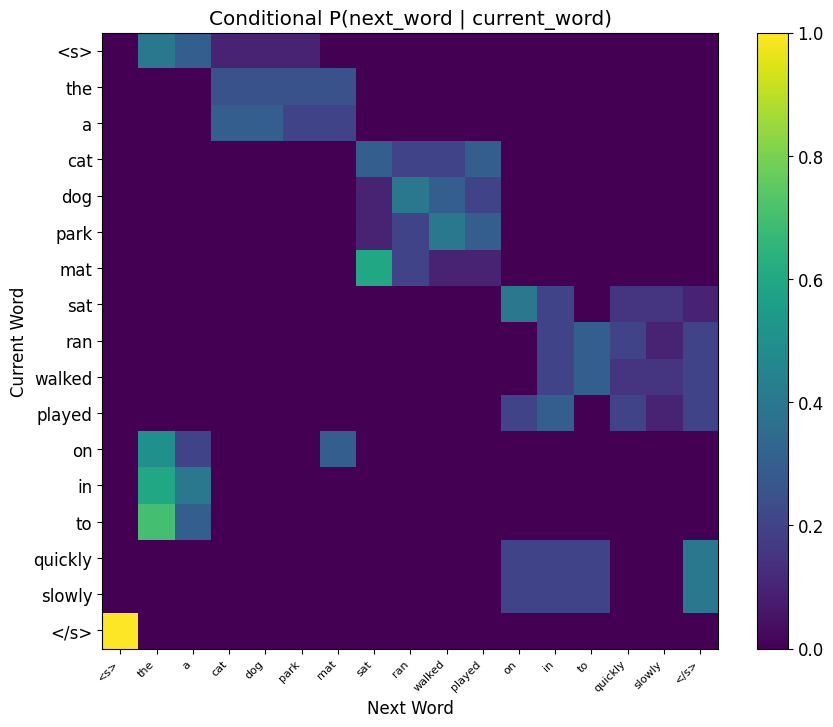

In [4]:
def setup_bigram_model() -> tuple[list[str], int, torch.Tensor, dict[str, int]]:
    """Set up a bigram language model with conditional probabilities."""
    vocab = [
        "<s>",
        "the",
        "a",
        "cat",
        "dog",
        "park",
        "mat",
        "sat",
        "ran",
        "walked",
        "played",
        "on",
        "in",
        "to",
        "quickly",
        "slowly",
        "</s>",
    ]
    vocab_size = len(vocab)

    # Create word-to-index mapping for clarity
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    # Define conditional probabilities P(next_word | current_word)
    # These represent realistic language model transitions
    conditional_probs = torch.zeros(vocab_size, vocab_size)

    transitions = {
        # Beginning of sentence typically followed by articles
        "<s>": {"the": 0.4, "a": 0.3, "cat": 0.1, "dog": 0.1, "park": 0.1},
        # Articles typically followed by nouns
        "the": {"cat": 0.25, "dog": 0.25, "park": 0.25, "mat": 0.25},
        "a": {"cat": 0.3, "dog": 0.3, "park": 0.2, "mat": 0.2},
        # Nouns typically followed by verbs
        "cat": {"sat": 0.3, "ran": 0.2, "walked": 0.2, "played": 0.3},
        "dog": {"ran": 0.4, "walked": 0.3, "played": 0.2, "sat": 0.1},
        "park": {"walked": 0.4, "played": 0.3, "ran": 0.2, "sat": 0.1},
        "mat": {"sat": 0.6, "ran": 0.2, "walked": 0.1, "played": 0.1},
        # Verbs can be followed by prepositions or adverbs
        "sat": {"on": 0.4, "in": 0.2, "quickly": 0.15, "slowly": 0.15, "</s>": 0.1},
        "ran": {"to": 0.3, "in": 0.2, "quickly": 0.2, "slowly": 0.1, "</s>": 0.2},
        "walked": {"to": 0.3, "in": 0.2, "quickly": 0.15, "slowly": 0.15, "</s>": 0.2},
        "played": {"in": 0.3, "on": 0.2, "quickly": 0.2, "slowly": 0.1, "</s>": 0.2},
        # Prepositions typically followed by articles or nouns
        "on": {"the": 0.5, "a": 0.2, "mat": 0.3},
        "in": {"the": 0.6, "a": 0.4},
        "to": {"the": 0.7, "a": 0.3},
        # Adverbs can end sentences or be followed by prepositions
        "quickly": {"on": 0.2, "in": 0.2, "to": 0.2, "</s>": 0.4},
        "slowly": {"on": 0.2, "in": 0.2, "to": 0.2, "</s>": 0.4},
        # End of sentence (for completeness, though not used in generation)
        "</s>": {"<s>": 1.0},
    }

    # Fill in the conditional probability matrix
    for current_word, next_words in transitions.items():
        current_idx = word_to_idx[current_word]
        for next_word, prob in next_words.items():
            next_idx = word_to_idx[next_word]
            conditional_probs[current_idx, next_idx] = prob

    return vocab, vocab_size, conditional_probs, word_to_idx


# Set up our bigram language model
vocab, vocab_size, conditional_probs, word_to_idx = setup_bigram_model()

# Visualize the conditional probabilities with a heatmap
plot_conditional_probability_heatmap(
    conditional_probs.numpy(),
    vocab,
    title="Conditional P(next_word | current_word)",
    xlabel="Next Word",
    ylabel="Current Word",
)

## 2. Sampling from Language Models

Now that we have our conditional probabilities, let's see how we can use them to generate text sequences. This demonstrates the core sampling process used in language model text generation.

The sampling process follows this pattern:
1. Start with a beginning token
2. Use conditional probabilities to sample the next word
3. Update the current context and repeat
4. Continue until we reach an end token or maximum length

In [5]:
def sample_from_bigram_model(
    conditional_probs: torch.Tensor,
    word_to_idx: dict[str, int],
    num_sequences: int = 1000,
    max_length: int = 10,
    temperature: float = 1.0,
) -> list[list[str]]:
    """
    Sample sequences from the bigram model with optional temperature control.
    """
    vocab = list(word_to_idx.keys())
    sequences = []

    start_idx = word_to_idx["<s>"]
    end_idx = word_to_idx["</s>"]

    for _ in range(num_sequences):
        sequence = ["<s>"]
        current_idx = start_idx

        for _ in range(max_length - 1):
            # Get next word probabilities and apply temperature
            next_probs = conditional_probs[current_idx]

            if temperature != 1.0:
                # Apply temperature: P_T(x) = softmax(log P(x) / T)
                logits = torch.log(next_probs + 1e-8)  # Add small epsilon to avoid log(0)
                next_probs = F.softmax(logits / temperature, dim=0)

            # Sample next word
            next_idx = int(torch.multinomial(next_probs, 1).item())
            next_word = vocab[next_idx]
            sequence.append(next_word)

            if next_idx == end_idx:
                break

            current_idx = next_idx

        sequences.append(sequence)

    return sequences


def demonstrate_sampling() -> list[list[str]]:
    """
    Demonstrate sampling from the bigram model and show example sentences.
    """
    # Generate a small number of sequences for demonstration
    sequences = sample_from_bigram_model(conditional_probs, word_to_idx, num_sequences=20, max_length=8)

    # Show a few example sentences
    for i in range(3):
        if i < len(sequences):
            clean_seq = [w for w in sequences[i] if w not in ["<s>", "</s>"]]
            print(f"{' '.join(clean_seq)}")

    return sequences


# Run the sampling demonstration
sample_sequences = demonstrate_sampling()

the dog ran quickly
cat walked slowly on the mat sat
dog played on mat sat on mat


## 3. Sampling-Based Estimation: Using Sampling to Estimate Unknown Quantities

**Key Principle**: Sampling is a powerful method for estimating unknown quantities when we have access to related known distributions.

In our case:
- **Known**: True conditional probabilities P(next_word | current_word) from our bigram model
- **Unknown**: What these conditional probabilities would be if estimated from limited data
- **Method**: Generate samples from the known conditional distribution and use them to estimate the conditional probabilities

This demonstrates the fundamental sampling principle:
$$P(y|x) = \lim_{N \to \infty} \frac{\text{count}(x, y)}{\text{count}(x)}$$

**Why is this useful?** In real-world scenarios, we often need to estimate conditional probabilities from limited data. This shows how estimation accuracy improves with more samples and helps us understand the convergence behavior.

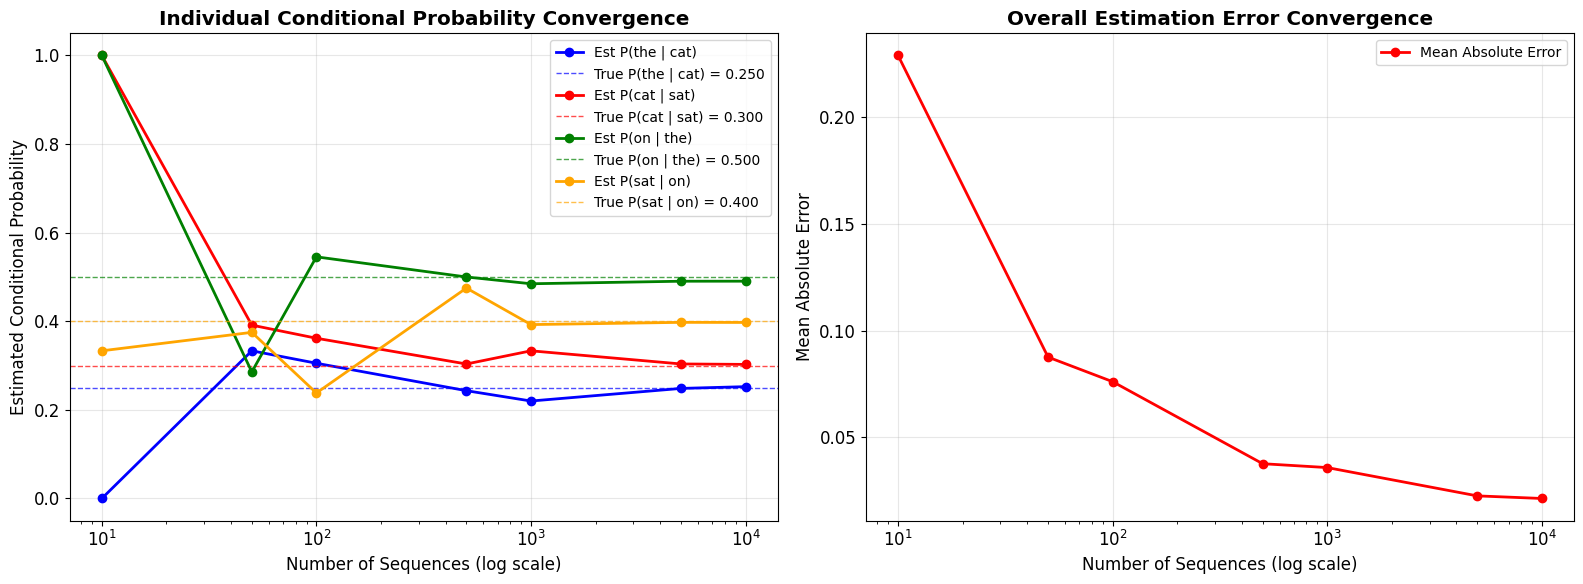

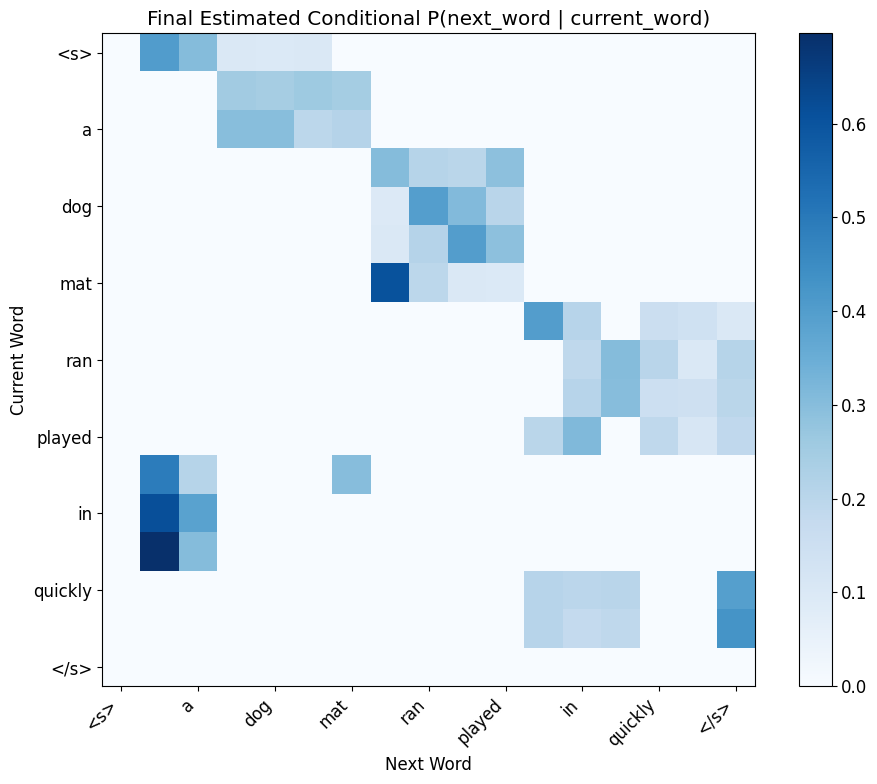

In [6]:
def estimate_joint_probabilities_from_sequences(
    sequences: list[list[int]], vocab_size: int
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Estimate joint probabilities from sampled sequences.
    """
    bigram_counts = torch.zeros((vocab_size, vocab_size))
    total_bigrams = 0

    # Count bigrams from sequences
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            current_idx = sequence[i]
            next_idx = sequence[i + 1]
            bigram_counts[current_idx, next_idx] += 1
            total_bigrams += 1

    # Estimate joint probabilities from counts
    joint_prob_estimated = bigram_counts / total_bigrams if total_bigrams > 0 else bigram_counts

    return bigram_counts, joint_prob_estimated


def estimate_conditional_probabilities_from_sequences(
    sequences: list[list[int]], vocab_size: int
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Estimate conditional probabilities P(next_word | current_word) from sampled sequences.
    """
    bigram_counts = torch.zeros((vocab_size, vocab_size))
    current_word_counts = torch.zeros(vocab_size)

    # Count bigrams and current words from sequences
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            current_idx = sequence[i]
            next_idx = sequence[i + 1]
            bigram_counts[current_idx, next_idx] += 1
            current_word_counts[current_idx] += 1

    # Estimate conditional probabilities P(next_word | current_word)
    conditional_prob_estimated = torch.zeros((vocab_size, vocab_size))
    for i in range(vocab_size):
        if current_word_counts[i] > 0:
            conditional_prob_estimated[i, :] = bigram_counts[i, :] / current_word_counts[i]

    return bigram_counts, conditional_prob_estimated


def demonstrate_sampling_based_estimation() -> (
    tuple[
        torch.Tensor,
        torch.Tensor,
        list[int],
        list[dict[str, float]],
        list[float],
        dict[str, float],
    ]
):
    """
    Demonstrate how to estimate conditional probabilities through sampling from known conditionals.
    Shows convergence of specific bigram probability estimates and overall estimation error.
    """

    # Sample with different numbers of sequences to show convergence
    sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000]

    # Select a few interesting bigrams to track
    target_bigrams = [("the", "cat"), ("cat", "sat"), ("on", "the"), ("sat", "on")]

    # Convert to indices and get true probabilities
    target_indices = []
    true_probabilities = {}
    for w1, w2 in target_bigrams:
        if w1 in word_to_idx and w2 in word_to_idx:
            i1, i2 = word_to_idx[w1], word_to_idx[w2]
            target_indices.append((i1, i2))
            true_prob = conditional_probs[i1, i2].item()
            true_probabilities[f"{w1}_{w2}"] = true_prob

    # Track convergence of these bigrams and overall error
    convergence_data = []
    mean_errors = []

    # Initialize variables to avoid unbound variable errors
    conditional_prob_estimated = torch.zeros((vocab_size, vocab_size))
    bigram_counts = torch.zeros((vocab_size, vocab_size))

    for num_sequences in sample_sizes:
        # Use the existing sampling function from section 2
        sequences = sample_from_bigram_model(
            conditional_probs,
            word_to_idx,
            num_sequences=num_sequences,
            max_length=8,
        )
        # Convert string sequences to index sequences for estimation
        sequences_idx = [[word_to_idx[word] for word in seq] for seq in sequences]
        # Estimate conditional probabilities from the sequences
        bigram_counts, conditional_prob_estimated = estimate_conditional_probabilities_from_sequences(
            sequences_idx, vocab_size
        )

        # Track specific bigram probabilities
        bigram_estimates = {}
        for (w1, w2), (i1, i2) in zip(target_bigrams, target_indices):
            prob = conditional_prob_estimated[i1, i2].item()
            bigram_estimates[f"{w1}_{w2}"] = prob

        convergence_data.append(bigram_estimates)

        # Calculate mean error across all bigrams with non-zero true probability
        errors = []
        for i in range(vocab_size):
            for j in range(vocab_size):
                true_prob = conditional_probs[i, j].item()
                if true_prob > 0:  # Only consider bigrams that actually exist
                    estimated_prob = conditional_prob_estimated[i, j].item()
                    error = abs(estimated_prob - true_prob)
                    errors.append(error)

        mean_error = sum(errors) / len(errors) if errors else 0.0
        mean_errors.append(mean_error)

    return (
        conditional_prob_estimated,
        bigram_counts,
        sample_sizes,
        convergence_data,
        mean_errors,
        true_probabilities,
    )


# Run the combined sampling-based estimation
(
    conditional_prob,
    bigram_counts,
    sample_sizes,
    convergence_data,
    mean_errors,
    true_probabilities,
) = demonstrate_sampling_based_estimation()

# Create two-panel visualization: individual bigram convergence and overall error
fig, axes = create_subplot_grid(1, 2, figsize=(16, 6))

# Left panel: Individual bigram convergence
bigram_names = list(convergence_data[0].keys())
colors = ["blue", "red", "green", "orange", "purple", "brown"]

for i, bigram_name in enumerate(bigram_names):
    probabilities = [data[bigram_name] for data in convergence_data]
    color = colors[i % len(colors)]

    # Plot estimated probabilities
    axes[0].plot(
        sample_sizes,
        probabilities,
        "o-",
        color=color,
        linewidth=2,
        markersize=6,
        label=f"Est P({bigram_name.replace('_', ' | ')})",
    )

    # Plot true probability as horizontal line
    true_prob = true_probabilities[bigram_name]
    axes[0].axhline(
        y=true_prob,
        color=color,
        linestyle="--",
        alpha=0.7,
        linewidth=1,
        label=f"True P({bigram_name.replace('_', ' | ')}) = {true_prob:.3f}",
    )

# Setup left panel with utility function
setup_axis_with_rotation(
    axes[0],
    title="Individual Conditional Probability Convergence",
    xlabel="Number of Sequences (log scale)",
    ylabel="Estimated Conditional Probability",
    fontsize=12,
)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale("log")
axes[0].legend(fontsize=10)

# Right panel: Overall mean error convergence
axes[1].plot(
    sample_sizes,
    mean_errors,
    "o-",
    color="red",
    linewidth=2,
    markersize=6,
    label="Mean Absolute Error",
)

# Setup right panel with utility function
setup_axis_with_rotation(
    axes[1],
    title="Overall Estimation Error Convergence",
    xlabel="Number of Sequences (log scale)",
    ylabel="Mean Absolute Error",
    fontsize=12,
)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale("log")
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Show the final estimated conditional probability heatmap
fig, ax = plt.subplots(figsize=(10, 8))
step = max(1, len(vocab) // 8)
tick_positions = range(0, len(vocab), step)
tick_labels = [vocab[i] for i in tick_positions]

plot_heatmap(
    conditional_prob.numpy(),
    title="Final Estimated Conditional P(next_word | current_word)",
    cmap="Blues",
    xlabel="Next Word",
    ylabel="Current Word",
    xticks=tick_positions,
    yticks=tick_positions,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    ax=ax,
)

plt.tight_layout()
plt.show()

## 4. Marginalization: Summing Over Variables

Marginalization allows us to compute the probability of one variable by summing over all possible values of other variables. This is crucial for working with complex probability distributions.

$$P(x) = \sum_y P(x, y)$$

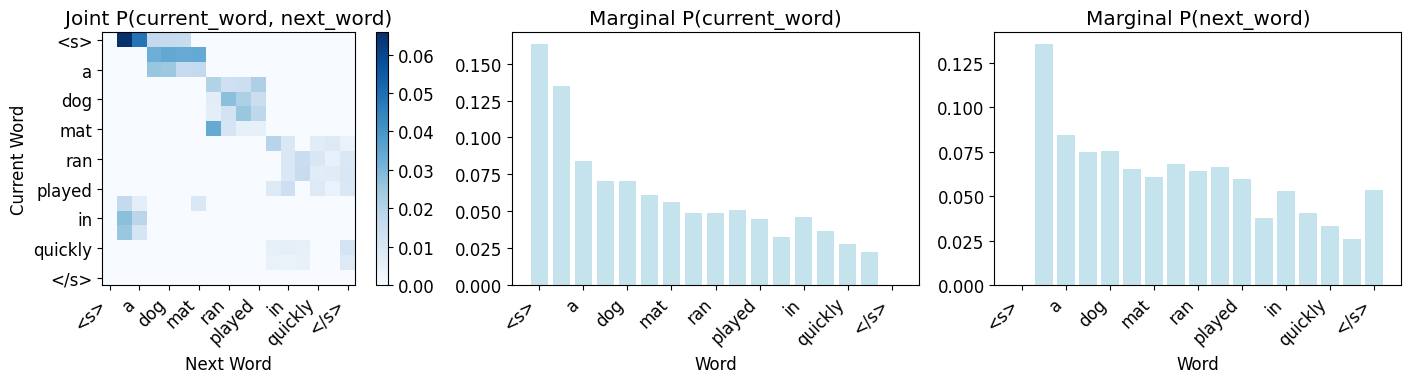

In [7]:
# Run the marginalization demonstration
# For this section, we need joint probabilities, so let's compute them from our estimated conditional probabilities
# We'll use the final conditional probabilities from section 3 and compute joint probabilities
# by sampling to get the marginal distribution of current words

# Sample a large number of sequences to get a good estimate of the marginal distribution
large_sample_sequences = sample_from_bigram_model(conditional_probs, word_to_idx, num_sequences=10000, max_length=8)
large_sample_sequences_idx = [[word_to_idx[word] for word in seq] for seq in large_sample_sequences]

# Get both joint and conditional probabilities from the large sample
_, joint_prob = estimate_joint_probabilities_from_sequences(large_sample_sequences_idx, vocab_size)

marginal_x_computed = torch.sum(joint_prob, dim=1)
marginal_y_computed = torch.sum(joint_prob, dim=0)

# Visualize marginalization
fig, axes = create_subplot_grid(1, 3, figsize=(15, 4))
# Show only a subset of labels for readability
step = max(1, len(vocab) // 8)
tick_positions = range(0, len(vocab), step)
tick_labels = [vocab[i] for i in tick_positions]

plot_heatmap(
    joint_prob.numpy(),
    title="Joint P(current_word, next_word)",
    cmap="Blues",
    xlabel="Next Word",
    ylabel="Current Word",
    xticks=tick_positions,
    yticks=tick_positions,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    ax=axes[0],
)

plot_bar_chart(
    marginal_x_computed.numpy(),
    title="Marginal P(current_word)",
    xlabel="Word",
    xticks=tick_positions,
    xticklabels=tick_labels,
    ax=axes[1],
)

plot_bar_chart(
    marginal_y_computed.numpy(),
    title="Marginal P(next_word)",
    xlabel="Word",
    xticks=tick_positions,
    xticklabels=tick_labels,
    ax=axes[2],
)

plt.tight_layout()
plt.show()

## 5. Latent Variables: Hidden Structure in Models

Latent variables are unobserved variables that help explain the relationship between observed variables.
In this example, we'll model sequences where:
- **x** = first word in the sequence (after "&lt;s")
- **y** = last word in the sequence (before "&lt;/s&gt;")
- **z** = everything else in between (the latent variable we marginalize over)

The key insight: P(x, y) = Σ_z P(x, y, z) = Σ_z P(x) P(z|x) P(y|z)

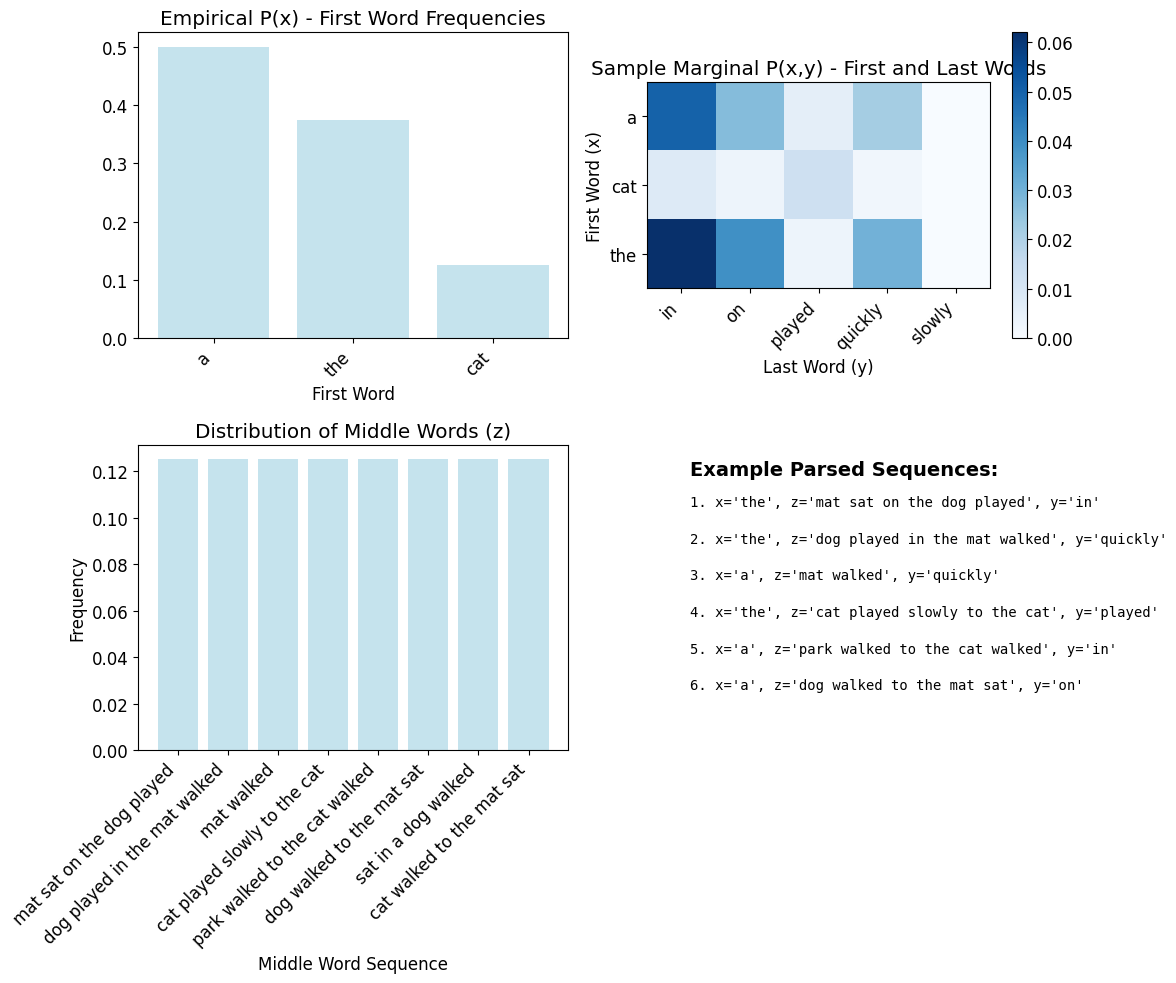

In [8]:
def demonstrate_latent_variables() -> tuple[torch.Tensor, dict[str, int], list[str], list[tuple[str, str, str]]]:
    """
    Demonstrate latent variables where z represents middle words between first (x) and last (y) words.
    Uses the bigram model from section 1 and sampling from section 2.
    """

    # Generate sequences using the bigram model from sections 1-2
    num_samples = 1000
    sequences = sample_from_bigram_model(conditional_probs, word_to_idx, num_sequences=num_samples, max_length=10)

    # Convert sequences from indices to words and parse into x, z, y structure

    parsed_examples = []
    xy_counts = {}  # Count occurrences of (x, y) pairs
    xyz_counts = {}  # Count occurrences of (x, z, y) triples

    for i, seq_words in enumerate(sequences):
        # sequences now contain words directly

        # Skip sequences that are too short (need at least <s>, x, y, </s>)
        if len(seq_words) < 4:
            continue

        # Parse into x, z, y
        x = seq_words[1]  # First word after <s>
        y = seq_words[-2]  # Last word before </s>
        z_words = seq_words[2:-2]  # Middle words
        z = " ".join(z_words) if z_words else "(empty)"

        # Count for empirical probability estimation
        xy_pair = (x, y)
        xyz_triple = (x, z, y)

        xy_counts[xy_pair] = xy_counts.get(xy_pair, 0) + 1
        xyz_counts[xyz_triple] = xyz_counts.get(xyz_triple, 0) + 1

        # Show first few examples
        if i < 8:
            parsed_examples.append((x, z, y))

    # Get unique first and last words for creating probability matrix
    all_x_words = set()
    all_y_words = set()
    for x, y in xy_counts:
        all_x_words.add(x)
        all_y_words.add(y)

    # Create sorted lists for consistent indexing
    x_words = sorted(all_x_words)
    y_words = sorted(all_y_words)

    # Create empirical marginal probability matrix P(x, y)
    # This is computed by marginalizing over all possible z values
    marginal_xy = torch.zeros(len(x_words), len(y_words))
    total_sequences = sum(xy_counts.values())

    for (x, y), count in xy_counts.items():
        if x in x_words and y in y_words:
            x_idx = x_words.index(x)
            y_idx = y_words.index(y)
            marginal_xy[x_idx, y_idx] = count / total_sequences

    # Show marginalization example for a common (x, y) pair
    example_xy = None
    max_count = 0
    for xy_pair, count in xy_counts.items():
        if count > max_count:
            max_count = count
            example_xy = xy_pair

    if example_xy:
        x_ex, y_ex = example_xy
        z_contributions = []
        total_prob = 0
        for (x, z, y), count in xyz_counts.items():
            if x == x_ex and y == y_ex:
                prob = count / total_sequences
                total_prob += prob
                z_contributions.append((z, prob))

    # Create word-to-index mapping for visualization
    word_to_idx_mapping = {word: idx for idx, word in enumerate(x_words + y_words)}

    return (marginal_xy, word_to_idx_mapping, x_words + y_words, parsed_examples)


# Run the latent variable demonstration
marginal_xy, word_to_idx_mapping, all_words, parsed_examples = demonstrate_latent_variables()

# Visualize the latent variable model
fig, axes = create_subplot_grid(2, 2, figsize=(12, 10))

# Extract first and last words for visualization (limit to most common ones)
x_words = sorted({x for x, _z, _y in parsed_examples})[:10]  # Top 10 first words
y_words = sorted({y for _x, _z, y in parsed_examples})[:10]  # Top 10 last words

# Create a subset of the marginal matrix for visualization
marginal_subset = torch.zeros(len(x_words), len(y_words))
for i, x_word in enumerate(x_words):
    for j, y_word in enumerate(y_words):
        if x_word in all_words and y_word in all_words:
            x_idx = all_words.index(x_word) if x_word in all_words else -1
            y_idx = all_words.index(y_word) if y_word in all_words else -1
            if x_idx >= 0 and y_idx >= 0 and x_idx < marginal_xy.shape[0] and y_idx < marginal_xy.shape[1]:
                marginal_subset[i, j] = marginal_xy[x_idx, y_idx]

# Plot 1: Empirical first word frequencies
x_counts = {}
for x, _z, _y in parsed_examples:
    x_counts[x] = x_counts.get(x, 0) + 1

top_x_words = sorted(x_counts.items(), key=lambda x: x[1], reverse=True)[:8]
x_words_plot = [word for word, _count in top_x_words]
x_probs_plot = torch.tensor([count / len(parsed_examples) for _word, count in top_x_words])

plot_bar_chart(
    x_probs_plot.numpy(),
    title="Empirical P(x) - First Word Frequencies",
    xlabel="First Word",
    ax=axes[0],
    xticks=range(len(x_words_plot)),
    xticklabels=x_words_plot,
)

# Plot 2: Sample of marginal probabilities P(x,y)
plot_heatmap(
    marginal_subset.numpy(),
    "Sample Marginal P(x,y) - First and Last Words",
    xlabel="Last Word (y)",
    ylabel="First Word (x)",
    cmap="Blues",
    xticks=range(len(y_words)),
    yticks=range(len(x_words)),
    xticklabels=y_words,
    yticklabels=x_words,
    ax=axes[1],
)

# Plot 3: Show z-word distribution for most common x,y pair
z_counts = {}
for _x, z, _y in parsed_examples:
    z_counts[z] = z_counts.get(z, 0) + 1

top_z_words = sorted(z_counts.items(), key=lambda x: x[1], reverse=True)[:8]
z_words_plot = [z for z, _count in top_z_words]
z_probs_plot = torch.tensor([count / len(parsed_examples) for _z, count in top_z_words])

plot_bar_chart(
    z_probs_plot.numpy(),
    title="Distribution of Middle Words (z)",
    xlabel="Middle Word Sequence",
    ylabel="Frequency",
    ax=axes[2],
    xticks=range(len(z_words_plot)),
    xticklabels=z_words_plot,
)

# Plot 4: Show example sequences as text
ax = axes[3]
ax.axis("off")
ax.text(
    0.1,
    0.9,
    "Example Parsed Sequences:",
    fontsize=14,
    fontweight="bold",
    transform=ax.transAxes,
)
y_pos = 0.8
for i, (x, z, y) in enumerate(parsed_examples[:6]):  # Show first 6 examples
    ax.text(
        0.1,
        y_pos,
        f"{i + 1}. x='{x}', z='{z}', y='{y}'",
        fontsize=10,
        transform=ax.transAxes,
        fontfamily="monospace",
    )
    y_pos -= 0.12

plt.tight_layout()
plt.show()

## 6. Temperature Sampling and Biased Estimates

When we don't sample from the true distribution, we get biased estimates. Temperature sampling modifies probabilities: $$P_T(x) = \frac{\exp(\log P(x) / T)}{\sum_i \exp(\log P(i) / T)}$$

Let's demonstrate this by comparing bigram probability convergence at temperature T=1.0 (unbiased) vs T=0.5 (biased).

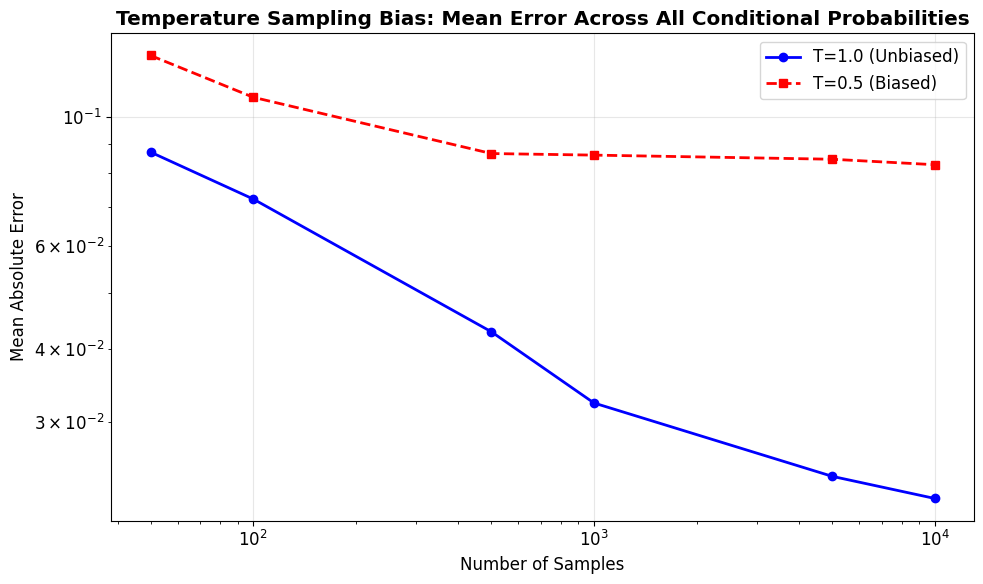

In [9]:
def demonstrate_temperature_bias() -> tuple[list[int], list[float], list[float], list[float], list[float]]:
    """
    Demonstrate how temperature sampling creates biased estimates by comparing
    convergence at T=1.0 vs T=0.5 across the entire conditional distribution.
    """

    # Sample sizes to test
    sample_sizes = [50, 100, 500, 1000, 5000, 10000]

    # Results storage
    mean_errors_t1 = []  # Temperature 1.0 (unbiased) - mean error across all bigrams
    max_errors_t1 = []  # Temperature 1.0 (unbiased) - max error across all bigrams
    mean_errors_t05 = []  # Temperature 0.5 (biased) - mean error across all bigrams
    max_errors_t05 = []  # Temperature 0.5 (biased) - max error across all bigrams

    torch.manual_seed(42)  # For reproducibility

    for n_samples in sample_sizes:
        # Temperature 1.0 (unbiased sampling)
        sequences_t1 = sample_from_bigram_model(
            conditional_probs,
            word_to_idx,
            num_sequences=n_samples,
            max_length=8,
            temperature=1.0,
        )
        # Convert string sequences to index sequences for estimation
        sequences_t1_idx = [[word_to_idx[word] for word in seq] for seq in sequences_t1]
        _, estimated_conditional_t1 = estimate_conditional_probabilities_from_sequences(sequences_t1_idx, vocab_size)

        # Calculate errors for all bigrams with non-zero true probability
        errors_t1 = []
        for i in range(vocab_size):
            for j in range(vocab_size):
                true_prob = conditional_probs[i, j].item()
                if true_prob > 0:  # Only consider bigrams that actually exist
                    estimated_prob = estimated_conditional_t1[i, j].item()
                    error = abs(estimated_prob - true_prob)
                    errors_t1.append(error)

        mean_error_t1 = sum(errors_t1) / len(errors_t1)
        max_error_t1 = max(errors_t1)
        mean_errors_t1.append(mean_error_t1)
        max_errors_t1.append(max_error_t1)

        # Temperature 0.5 (biased sampling - more peaked)
        sequences_t05 = sample_from_bigram_model(
            conditional_probs,
            word_to_idx,
            num_sequences=n_samples,
            max_length=8,
            temperature=0.5,
        )
        # Convert string sequences to index sequences for estimation
        sequences_t05_idx = [[word_to_idx[word] for word in seq] for seq in sequences_t05]
        _, estimated_conditional_t05 = estimate_conditional_probabilities_from_sequences(sequences_t05_idx, vocab_size)

        # Calculate errors for all bigrams with non-zero true probability
        errors_t05 = []
        for i in range(vocab_size):
            for j in range(vocab_size):
                true_prob = conditional_probs[i, j].item()
                if true_prob > 0:  # Only consider bigrams that actually exist
                    estimated_prob = estimated_conditional_t05[i, j].item()
                    error = abs(estimated_prob - true_prob)
                    errors_t05.append(error)

        mean_error_t05 = sum(errors_t05) / len(errors_t05)
        max_error_t05 = max(errors_t05)
        mean_errors_t05.append(mean_error_t05)
        max_errors_t05.append(max_error_t05)

    return sample_sizes, mean_errors_t1, max_errors_t1, mean_errors_t05, max_errors_t05


# Run the temperature bias demonstration
sample_sizes, mean_errors_t1, max_errors_t1, mean_errors_t05, max_errors_t05 = demonstrate_temperature_bias()

# Visualize the comparison - focus on mean error only
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean errors
ax.loglog(
    sample_sizes,
    mean_errors_t1,
    "b-",
    linewidth=2,
    label="T=1.0 (Unbiased)",
    marker="o",
)
ax.loglog(
    sample_sizes,
    mean_errors_t05,
    "r--",
    linewidth=2,
    label="T=0.5 (Biased)",
    marker="s",
)

# Setup axis with utility function
setup_axis_with_rotation(
    ax,
    title="Temperature Sampling Bias: Mean Error Across All Conditional Probabilities",
    xlabel="Number of Samples",
    ylabel="Mean Absolute Error",
    fontsize=12,
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()